##初始代码
#!/bin/bash

# === 设置路径 ===
BOOK_DIR="/home/xqgao/2025/MIT/Awesome-Computational-Imaging/compimg_book"
CHAPTERS_DIR="/home/xqgao/2025/MIT/Awesome-Computational-Imaging/chapters"
TOC_FILE="$BOOK_DIR/_toc.yml"
GITHUB_USER="tensor2023"
REPO_NAME="Awesome-Computational-Imaging"

# （可选）如果设置了 chapter 名，只构建这一章
BUILD_CHAPTER=""

# === 0. 处理传入参数（可选分批build）===
if [[ $# -gt 0 ]]; then
    if [[ $1 == --chapter ]]; then
        BUILD_CHAPTER="$2"
        echo "🛠 Only building chapter: $BUILD_CHAPTER"
    fi
fi

# # === 1. ipynb 转为 md（在原目录生成 .md，保留 .ipynb）===
# cd "$CHAPTERS_DIR"
# find . -name "*.ipynb" | while read -r ipynb_file; do
#     nb_dir="$(dirname "$ipynb_file")"  # ipynb所在的目录
#     jupyter nbconvert --to markdown "$ipynb_file" --output-dir "$nb_dir"
#     echo "✅ Converted $ipynb_file -> $nb_dir"
# done
# echo "🎯 All .ipynb files are now properly converted to .md!"


# === 1. 保存当前工作区 ===
echo "💾 Saving current changes..."
git add .
git commit -m "🔖 Save current files before deploy" || echo "⚠️ No changes to commit."

# # === 2. 清空 compimg_book/chapters/，重新复制 .md 和 *_files ===
# echo "🔄 Preparing compimg_book/chapters..."
# rm -rf "$BOOK_DIR/chapters"
# mkdir -p "$BOOK_DIR/chapters"

# # === 2.1 复制所有 .md 文件（保持结构，并显示每次复制信息）===
# cd "$CHAPTERS_DIR" #只对里面的md和_files进行操作
# find . -name "*.md" | while read -r md_file; do
#     dst_path="$BOOK_DIR/chapters/$(dirname "$md_file" | sed 's|^\./||')"
#     mkdir -p "$dst_path"
#     cp "$md_file" "$dst_path/"
#     echo "✅ Copied: $md_file --> $dst_path/"
# done

# # === 2.2 复制所有 *_files 文件夹（图片资源，并显示每次复制信息）===
# find . -type d -name "*_files" | while read -r d; do
#     dst_path="$BOOK_DIR/chapters/$(dirname "$d" | sed 's|^\./||')"
#     mkdir -p "$dst_path"
#     cp -r "$d" "$dst_path/"
#     echo "📂 Copied folder: $d --> $dst_path/"
# done



# echo "✅ All .md and *_files copied to $BOOK_DIR/chapters"

# # === 3. 确保 intro.md 存在 ===
# if [[ ! -s "$BOOK_DIR/intro.md" ]]; then
#     echo "# $REPO_NAME" > "$BOOK_DIR/intro.md"
#     echo "✅ Auto-generated intro.md"
# fi

# # === 4. 检查 TOC 文件是否存在 ===
# if [[ ! -f "$TOC_FILE" ]]; then
#     echo "❌ Error: _toc.yml not found at $TOC_FILE"
#     exit 1
# fi

# === 5. 生成 HTML 页面 ===
echo "🧹 Cleaning old build..."
rm -rf "$BOOK_DIR/_build"

echo "📘 Building Jupyter Book..."
if [[ -n "$BUILD_CHAPTER" ]]; then
    jupyter-book build "$BOOK_DIR/chapters/$BUILD_CHAPTER"
else
    jupyter-book build "$BOOK_DIR"
fi

if [[ $? -ne 0 ]]; then
    echo "❌ jupyter-book build failed. Please fix your TOC or markdown files first."
    exit 1
fi
# === 6. 直接用 subtree 推送 HTML 到 docs 分支，不切分支 ===

echo "🚀 Pushing built HTML files to docs branch..."
# 先 add _build/html
git add compimg_book/_build/html

# 再 commit
git commit -m "✨ Build website for deploy"

# 然后 subtree push
# 生成一个新的 commit，只包含 compimg_book/_build/html 的内容
git subtree split --prefix=compimg_book/_build/html -b deploy-docs
git push origin deploy-docs:docs --force


if [[ $? -ne 0 ]]; then
    echo "❌ Failed to push to docs branch."
    exit 1
fi

echo ""
echo "✅ Done! Successfully deployed clean HTML to docs branch!"
echo "🔗 View it at: https://$GITHUB_USER.github.io/$REPO_NAME/"


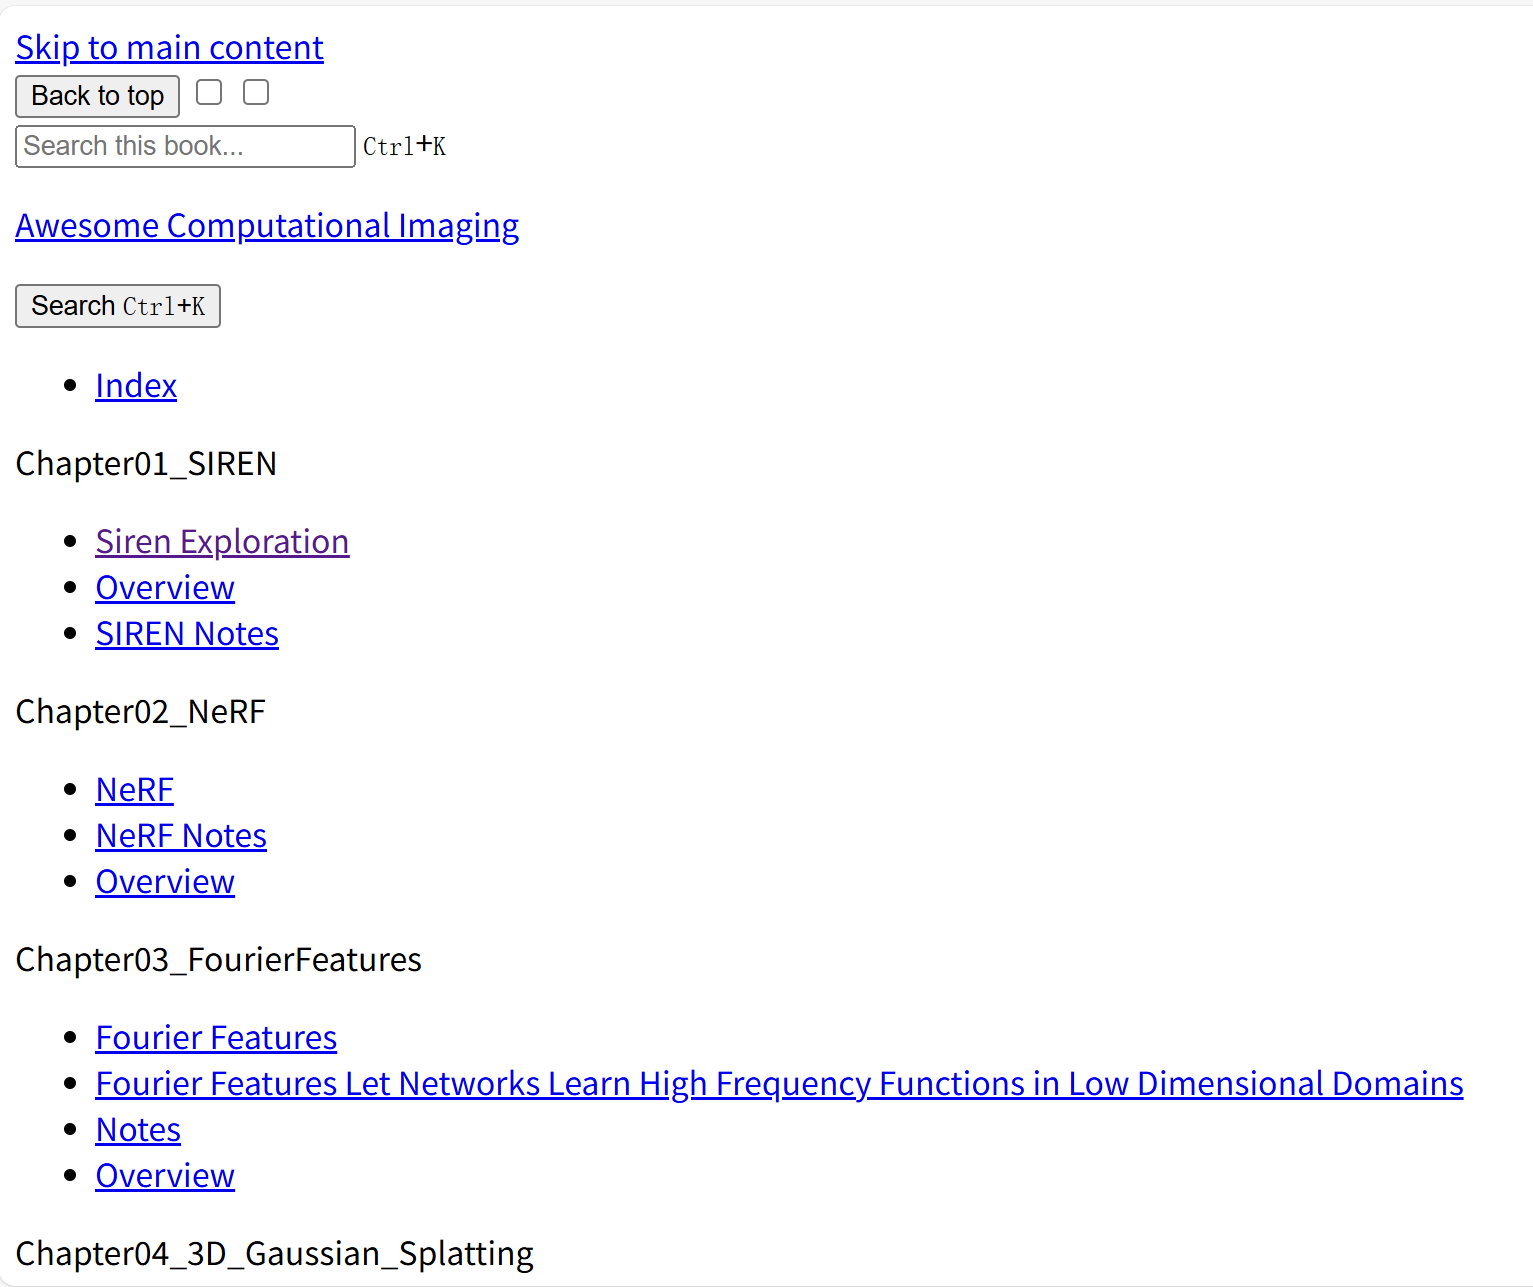